In [1]:
using ODE
using DifferentialEquations
using Pandas
using Plots
using Distributions
using ApproxBayes
using DiffEqBayes
using ModelingToolkit
# using Stan
# using ParameterizedFunctions


┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly C:\Users\leann\.julia\packages\Gadfly\09PWZ\src\mapping.jl:228


In [2]:
######this is all setting up, ignore######

include("setup_ABC.jl")
time1= 10000.0
problm = ODEProblem(AA_simple,init,(0.,time1))
#the line above runs the single cell model with AA. no cell growth or nitrogenase
# println("running with parameters $k_cat_AA-$k_a_NH4-$k_NH4-$k_a_AA-$k_NH4_AA-$k_ribo_a")
solved = ODE.solve(problm)
df1= DataFrame(solved)
println("burn in complete")
input2 = 10000.0
time2 = time1 + input2
endstate = size(solved,2)
init2 =solved[endstate]
problm2 = ODEProblem(AA_popn_growth,init2,(time1,time2))
println("the initial conditions are:")
init2

burn in complete
the initial conditions are:


25-element Array{Float64,1}:
      1.0e11            
   4407.834024297837    
    321.53513436957564  
   1615.411204884411    
      7.370060728234487 
    321.5351343695751   
      7.370060728234496 
     20.086443609166075 
     20.086443609166114 
  70475.8723133415      
    143.0746019854696   
   4402.6592546542915   
   3263.1432462906946   
      1.6372852617556957
   1000.0               
      0.0               
      0.0               
      0.0               
      0.0               
      1.0               
  46152.56607108405     
 413176.0417655678      
  69912.92166676397     
   4367.491476055563    
   1602.507543639397    

## The example code from ModellingToolkit:
Useful to define the system properly

https://github.com/JuliaDiffEq/ModelingToolkit.jl

## Example code from DiffEqBayes
(Out of date but still informative since we already have the system defined from the example above)

https://github.com/JuliaDiffEq/DiffEqBayes.jl

In [3]:
# f1 = @ode_def_nohes LotkaVolterraTest1 begin
#  dx = a*x - x*y
#  dy = -3*y + x*y
# end a

# p = [1.5]
# u0 = [1.0,1.0]
# tspan = (0.0,10.0)
# prob1 = ODEProblem(f1,u0,tspan,p)

# σ = 0.01                         # noise, fixed for now
# t = collect(linspace(1,10,10))   # observation times
# sol = solve(prob1,Tsit5())

# randomized = VectorOfArray([(sol(t[i]) + σ * randn(2)) for i in 1:length(t)])
# data = convert(Array,randomized)

# bayesian_result_abc = abc_inference(prob1, Tsit5(), t, data, [Normal(1.5, 1)];
#                                 num_samples=500)

## Defining the parameters, variables and equations for my system

In [4]:
@parameters t

@variables s_out(t) rmr(t) em(t) rmq(t) rmt(t) et(t) rmm(t) mt(t) mm(t) q(t) si(t) mq(t) mr(t) r(t) NH4(t) nit_mrna(t) nit_mrna_ribo(t) nit(t) NH4_ex(t) N(t) a(t) AA(t) AA_prot(t) AA_mrna(t) AA_mrna_ribo(t)


@parameters k_cat_AA
gam= (gmax*a*AA)/(k_ribo_a*k_ribo_a_AA+k_ribo_a_AA*a+k_ribo_AA_a*AA+a*AA) #updated gamma equation that uses both ATP and AA
ttrate= (rmq + rmr + rmt + rmm + nit_mrna_ribo+AA_mrna_ribo)*gam #total translation rate (sum of the mRNA/ribosome complexes times translation rate)
lam= ttrate/M
nucat= em*vm*si/(Km + abs(si)) 
AA_vo = ((k_cat_AA*2*a*NH4)/(k_a_NH4*k_a))/(1+(1+(AA/k_a_AA))+(NH4/k_a_NH4)+(1+(AA/k_NH4_AA))+(NH4/k_NH4))
new_AA = AA_vo*AA_prot
AA_a_use = new_AA*2 #each AA produced uses x number of ATP molecules
AA_NH4_use = new_AA*2 #each AA produced uses 2 NH4 molecules
export_rate = 0 #export rate of NH4
fixation = 0
death_rate = 0
k_ribo_a_AA = 10000.0
k_ribo_AA_a = 10000.0
k_a = 10.0


k_a_NH4 = 10.0
k_NH4 = 10.0
k_a_AA = 10.0
k_NH4_AA = 10.0
k_ribo_a = 10.0


@derivatives D'~t

eqs = [
    D(s_out)~ 0 #((-et*vt*s_out/(Kt+s_out))*N)-ds*s_out+(export_rate*NH4*50)+1e7
    D(rmr)~ kb*r*mr-ku*rmr-(gam/nr)*rmr-lam*rmr
    D(em)~ (gam/nx)*rmm-lam*em
    D(rmq)~ kb*r*mq-ku*rmq-(gam/nx)*rmq-lam*rmq
    D(rmt)~ kb*r*mt-ku*rmt-gam/nx*rmt-lam*rmt
    D(et)~ (gam/nx)*rmt-lam*et
    D(rmm)~ kb*r*mm-ku*rmm-gam/nx*rmm-lam*rmm
    D(mt)~ (we*a/(thetax+a))+ku*rmt+(gam/nx)*rmt-kb*r*mt-dm*mt-lam*mt
    D(mm)~ (we*a/(thetax+a))+ku*rmm+(gam/nx)*rmm-kb*r*mm-dm*mm-lam*mm
    D(q)~ (gam/nx)*rmq-lam*q
    D(si)~ (et*vt*s_out/(Kt+s_out))-nucat-lam*si
    D(mq)~ (wq*a/(thetax+a)/(1+(q/Kq)^nq))+ku*rmq+(gam/nx)*rmq-kb*r*mq-dm*mq-lam*mq
    D(mr)~ (wr*a/(thetar+a))+ku*rmr+(gam/nr)*rmr-kb*r*mr-dm*mr-lam*mr
    D(r)~ ku*rmr+ku*rmt+ku*rmm+ku*rmq+(gam/nr)*rmr+(gam/nr)*rmr+(gam/nx)*rmt+(gam/nx)*rmm+(gam/nx)*rmq-kb*r*mr-kb*r*mt-kb*r*mm-kb*r*mq+ku*nit_mrna_ribo+(gam/nx)*nit_mrna_ribo-kb*r*nit_mrna+ku*AA_mrna_ribo+(gam/nx)*AA_mrna_ribo-kb*r*AA_mrna-lam*r
    D(NH4)~ 0 #fixation*nit-export_rate*NH4-lam*NH4-AA_NH4_use+2.3e6
    D(nit_mrna)~ 0 #(v_nit*a/(thetax + a))+(ku*nit_mrna_ribo)+(gam/nx*nit_mrna_ribo)-(kb*r*nit_mrna)-(dm*nit_mrna)-(lam*nit_mrna) #num of free nitrogenase coding mRNA
    D(nit_mrna_ribo)~ 0 #(kb*r*nit_mrna)-(ku*nit_mrna_ribo)-(gam/nx*nit_mrna_ribo)-(lam*nit_mrna_ribo) #num of nit mRNA-ribosome complexes
    D(nit)~ 0 #(gam/nx)*nit_mrna_ribo-lam*nit #num of nitrogenase proteins
    D(NH4_ex)~ 0 #(export_rate*NH4)#total num of NH4 molecules exported this timestep
    D(N)~ 0 #lam*N-death_rate*N #the change in num of bacterial cells instead of just loss to dilution
    D(a)~ ns*nucat-ttrate-fixation*nit-AA_a_use-lam*a
    D(AA)~ new_AA-ttrate-lam*AA
    D(AA_prot)~ (gam/nx)*AA_mrna_ribo-lam*AA_prot
    D(AA_mrna)~ ((w_AA*a/(thetax+a)))+(ku*AA_mrna_ribo)+(gam/nx*AA_mrna_ribo)-(kb*r*AA_mrna)-(dm*AA_mrna)-(lam*AA_mrna)
    D(AA_mrna_ribo)~ (kb*r*AA_mrna)-(ku*AA_mrna_ribo)-(gam/nx*AA_mrna_ribo)-(lam*AA_mrna_ribo)
];

println("System defined successfully")

System defined successfully


## building an ODE problem with the parameters, variables and equations 

Uses the final values from the burn in stage (init2) done in set up as the initial values for this ODE problem

Sets the problem to run from time1 to time2 since the burn in stage was already run from time zero to time1

In [5]:

de = ODESystem(eqs, t, [s_out, rmr, em, rmq, rmt, 
        et, rmm, mt, mm, q, si, mq, mr, r, NH4, nit_mrna,
        nit_mrna_ribo, nit, NH4_ex, N, a, AA, AA_prot, 
        AA_mrna, AA_mrna_ribo],[k_cat_AA]);

f = ODEFunction(de, [s_out, rmr, em, rmq, 
        rmt, et, rmm, mt, mm, q, si, mq, mr, 
        r, NH4, nit_mrna, nit_mrna_ribo, nit, 
        NH4_ex, N, a, AA, AA_prot, AA_mrna, AA_mrna_ribo], [k_cat_AA]);

prob_abc = ODEProblem(f, init, (0.,time1))


ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 10000.0)
u0: [1.0e11, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 1.0, 1000.0, 50000.0, 1.0, 0.0, 0.0]

In [6]:

de = ODESystem(eqs, t, [s_out, rmr, em, rmq, rmt, 
        et, rmm, mt, mm, q, si, mq, mr, r, NH4, nit_mrna,
        nit_mrna_ribo, nit, NH4_ex, N, a, AA, AA_prot,
        AA_mrna, AA_mrna_ribo],[k_cat_AA])

f = ODEFunction(de)
p = [10.0]
prob_abc = ODEProblem(f, init, (0.,time1),p)


ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 10000.0)
u0: [1.0e11, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 1.0, 1000.0, 50000.0, 1.0, 0.0, 0.0]

In [ ]:
sol = solve(prob_abc)

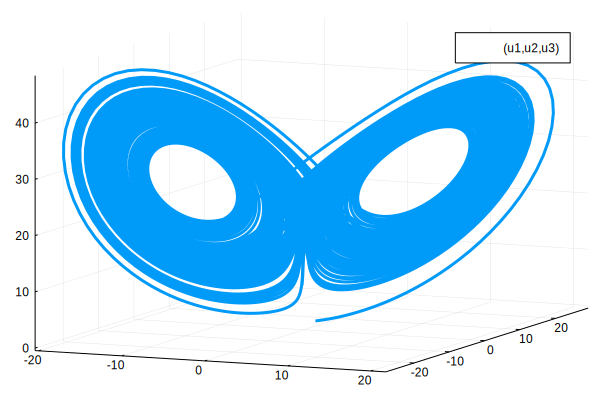

In [14]:
@parameters t σ ρ β
@variables x(t) y(t) z(t)
@derivatives D'~t
eqs = [D(x) ~ σ*(y-x),
       D(y) ~ x*(ρ-z)-y,
       D(z) ~ x*y - β*z]

de = ODESystem(eqs, t, [x,y,z], [σ,ρ,β])

f = ODEFunction(de)

u₀ = ones(3)
tspan = (0.0,100.0)
p = [10.0,28.0,10/3]
prob = ODEProblem(f,u₀,tspan,p)
sol = solve(prob,Tsit5())

Plots.plot(sol,vars=(1,2,3))

In [ ]:
k_cat_AA = 10.0
solved = ODE.solve(prob_abc)

In [15]:
target_data = [9.6e8,1.8e10]#,0.1] #number of amino acids, ATP #and growth rate in an average E. coli. growth rate needs to be checked
#leaving out the growth rate for now since it is not an output of the ODEs, its an internal parameter

3-element Array{Float64,1}:
 9.6e8 
 1.8e10
 0.1   

In [16]:
priors = [Uniform(0.1,10000.)]
#     ,Uniform(0.1,10000.),
#         Uniform(0.1,10000.),Uniform(0.1,10000.),
#         Uniform(0.1,10000.),Uniform(0.1,10000.)]

abc_result = abc_inference(prob_abc, AutoTsit5(Rosenbrock23()),time2,target_data,priors,
    num_samples = 100)


Preparing to run in serial on 1 processor


DimensionMismatch: DimensionMismatch("first array has length 3 which does not match the length of the second, 50.")

In [100]:
setup = ABCSMC(f, #simulation function
    6, #num of params
    1000.0, #error threshold target
    Prior([Uniform(0.1,10000.),Uniform(0.1,10000.),
        Uniform(0.1,10000.),Uniform(0.1,10000.),
        Uniform(0.1,10000.),Uniform(0.1,10000.)]
)
)

smc = runabc(setup, target_data, verbose = true, progress= true)

##################################################
Use ABC rejection to get first population
Preparing to run in serial on 1 processor


UndefRefError: UndefRefError: access to undefined reference

In [115]:
solved = solve(prob_abc)

MethodError: MethodError: no method matching Float64(::Operation)
Closest candidates are:
  Float64(::T) where T<:Number at boot.jl:718
  Float64(!Matched::Int8) at float.jl:60
  Float64(!Matched::Int16) at float.jl:60
  ...

In [49]:
params = (k_cat_AA) #, k_a_NH4, k_NH4, k_a_AA, k_NH4_AA, k_ribo_a)
problm = ODEProblem(AA_popn_growth,init2,(time1,time2));
# solved = solve(problm)
priors = [Normal(5000,10000)]


ABC_result = abc_inference(problm, Tsit5(), time2, target_data, priors;
    num_samples = 500, ϵ = 1000, progress = true, ABCalgorithm = ABCSMC)

MethodError: MethodError: no method matching ABCSMC(::DiffEqBayes.var"#simfunc#22"{Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},ODEProblem{Array{Float64,1},Tuple{Float64,Float64},true,DiffEqBase.NullParameters,ODEFunction{true,typeof(AA_popn_growth),LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},DiffEqBase.StandardODEProblem},Float64,typeof(Distances.euclidean),Tsit5}, ::Int64, ::Int64, ::Prior; nparticles=500, maxiterations=100000)
Closest candidates are:
  ABCSMC(::Function, ::Int64, !Matched::Float64, ::Prior; maxiterations, constants, nparticles, α, ϵ1, convergence, kernel) at /Users/leanne/.julia/packages/ApproxBayes/EK19t/src/types.jl:109